# Importation des librairies

In [ ]:
import BankModel
import header
import ProcessRakuten

import numpy as np
import pandas as pd
import spacy

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

# Importation des données

In [ ]:
X_train = pd.read_csv(
    "/Users/welto/Library/CloudStorage/OneDrive-CentraleSupelec/2A/CASA/RakutenPjct/data/X_train_update.csv",
    sep=','
)

Y_train = pd.read_csv(
    "/Users/welto/Library/CloudStorage/OneDrive-CentraleSupelec/2A/CASA/RakutenPjct/data/Y_train_CVw08PX.csv",
    sep=','
)

# Preprocessing

### Supression des colonnes inutilisées

In [ ]:
X_train = X_train.drop(
    labels=['Unnamed: 0', 'imageid', 'description']
    , axis=1
)
Y_train = Y_train.drop(
    labels='Unnamed: 0',
    axis=1
)

In [ ]:
X_train.shape, Y_train.shape

### Séparation train-test

In [ ]:
X_train, X_test = train_test_split(
    X_train,
    test_size=0.2,
    random_state=42
)
Y_train, Y_test = train_test_split(
    Y_train,
    test_size=0.2,
    random_state=42
)

In [ ]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

### Conversion en listes

In [ ]:
### Tokenisation et cleaning

In [ ]:
X_train_raw_designation = X_train['designation'].tolist()
X_test_raw_designation = X_test['designation'].tolist()

In [ ]:
spacy_nlp = spacy.load("fr_core_news_sm")

X_train_raw_designation_clean = []
X_test_raw_designation_clean = []

a = len(X_train_raw_designation)
b = len(X_test_raw_designation)

header.progress_bar(
    0,
    a,
    prefix='Progress:',
    suffix='Complete',
    length=50
)

for k in range(a):
    X_train_raw_designation_clean.append(
        header.raw_to_tokens(
            X_train_raw_designation[k],
            spacy_nlp
        )
    )
    header.progress_bar(
        k + 1,
        a,
        prefix='X_train_raw_designation_clean:',
        suffix='Complete',
        length=50
    )

for k in range(b):
    X_test_raw_designation_clean.append(
        header.raw_to_tokens(
            X_test_raw_designation[k],
            spacy_nlp
        )
    )
    header.progress_bar(
        k + 1,
        b,
        prefix='X_test_raw_designation_clean:',
        suffix='Complete',
        length=50
    )

### Vectorisation

In [ ]:
tfidf = TfidfVectorizer()

X_train_tfidf = tfidf.fit_transform(X_train_raw_designation_clean)
X_test_tfidf = tfidf.transform(X_test_raw_designation_clean)

print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_test_tfidf shape:", X_test_tfidf.shape)

In [ ]:
X_train_tfidf.todense(), X_test_tfidf.todense()

# Entraînement

In [ ]:
fast_coeff = 1

## Gradient Boosting (ne fonctionne pas)

In [ ]:
params = {
    'n_estimators': [100, 150, 200, 250, 300],
    'learning_rate': [0.02, 0.03, 0.04, 0.05, 0.1]
}

gb = GradientBoostingClassifier()

gb_grid = GridSearchCV(
    estimator=gb,
    param_grid=params,
    scoring='accuracy',
    cv=10, n_jobs=-1,
    verbose=10
)

gb_grid.fit(
    X_train_tfidf,
    Y_train
)

Y_pred_gb = gb_grid.predict(X_test_tfidf)
print(
    "Accuracy score:",
    accuracy_score(
        Y_test,
        Y_pred_gb
    )
)

# SVM

13min

In [ ]:
svm = SVC()

svm.fit(
    X_train_tfidf[:X_train_tfidf.shape[0]//fast_coeff],
    Y_train[:len(Y_train)//fast_coeff]
)

Y_pred_svm = svm.predict(X_test_tfidf[:X_test_tfidf.shape[0]//fast_coeff])

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': [10, 1, 0.1, 0.01],
    'kernel': ['rbf']
}

grid = GridSearchCV(
    SVC(),
    param_grid,
    refit=True,
    verbose=4
)
grid.fit(
    X_train_tfidf[:X_train_tfidf.shape[0]//fast_coeff],
    Y_train[:len(Y_train)//fast_coeff]
)

Y_pred_svm = grid.predict(X_test_tfidf[:X_test_tfidf.shape[0]//fast_coeff])

In [ ]:
grid.best_params_

In [ ]:
print(
    "f1 score :",
    f1_score(
        Y_test[:X_test_tfidf.shape[0]//fast_coeff],
        Y_pred_svm,
        average='macro'
    )
)
print(
    "accuracy score :",
    accuracy_score(
        Y_test[:X_test_tfidf.shape[0]//fast_coeff],
        Y_pred_svm
    )
)

# Full

X_train_raw_designation_clean n°1/10 : |██████████████████████████████████████████████████| 100.0% Complete
X_test_raw_designation_clean n°1/10 : |██████████████████████████████████████████████████| 100.0% Complete
Preprocessed in 0h 1min 7s
(13586, 26138) (3396, 26138)
Model trained in 0h 0min 21s
X_train_raw_designation_clean n°2/10 : |██████████████████████████████████████████████████| 100.0% Complete
X_test_raw_designation_clean n°2/10 : |██████████████████████████████████████████████████| 100.0% Complete
Preprocessed in 0h 1min 8s
(13586, 26093) (3396, 26093)
Model trained in 0h 0min 21s
X_train_raw_designation_clean n°3/10 : |██████████████████████████████████████████████████| 100.0% Complete
X_test_raw_designation_clean n°3/10 : |██████████████████████████████████████████████████| 100.0% Complete
Preprocessed in 0h 1min 8s
(13586, 25990) (3396, 25990)
Model trained in 0h 0min 21s
X_train_raw_designation_clean n°4/10 : |██████████████████████████████████████████████████| 100.0% C

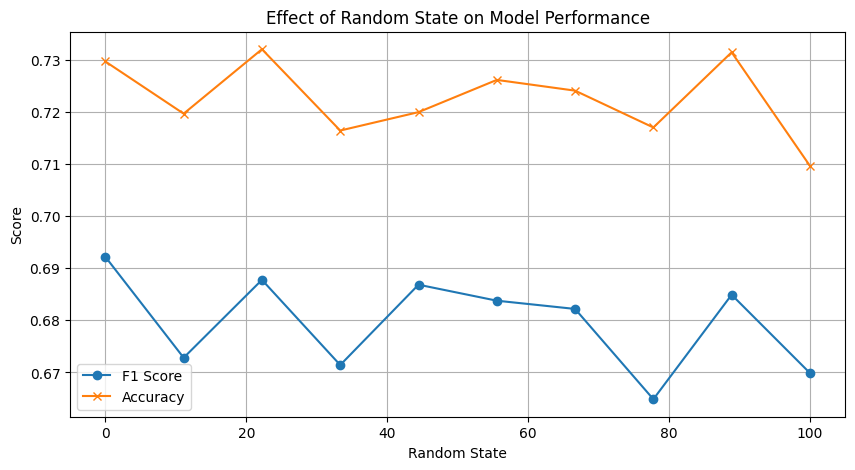

In [6]:
import BankModel
import header
import ProcessRakuten

import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt

import warnings
import time

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

def convert_seconds(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60
    return hours, minutes, secs

# Ignore warnings
warnings.filterwarnings("ignore")

# Évolution des scores en fonction du random state
random_state = np.linspace(0, 100, 10)

# Séparation train-test
f1 = []
accuracy = []
c = 1
tot = len(random_state)

full_time_start = time.time()

for number in random_state :
    # Importation des données
    X_train = pd.read_csv(
        "/Users/welto/Library/CloudStorage/OneDrive-CentraleSupelec/2A/CASA/RakutenPjct/data/X_train_update.csv",
        sep=','
    )

    Y_train = pd.read_csv(
        "/Users/welto/Library/CloudStorage/OneDrive-CentraleSupelec/2A/CASA/RakutenPjct/data/Y_train_CVw08PX.csv",
        sep=','
    )

    # Preprocessing
    fast_coeff = 5

    # Suppression des colonnes inutiles
    X_train = X_train.drop(
        labels=['Unnamed: 0', 'imageid', 'description']
        , axis=1
    )
    Y_train = Y_train.drop(
        labels='Unnamed: 0',
        axis=1
    )

    X_train, X_test = train_test_split(
        X_train,
        test_size=0.2,
        random_state=int(number)
    )
    Y_train, Y_test = train_test_split(
        Y_train,
        test_size=0.2,
        random_state=int(number)
    )

    # Tokenisation et cleaning
    X_train_raw_designation = X_train['designation'][:X_train.shape[0]//fast_coeff].tolist()
    X_test_raw_designation = X_test['designation'][:X_test.shape[0]//fast_coeff].tolist()
    Y_train = Y_train['prdtypecode'][:Y_train.shape[0]//fast_coeff].tolist()
    Y_test = Y_test['prdtypecode'][:Y_test.shape[0]//fast_coeff].tolist()

    spacy_nlp = spacy.load("fr_core_news_sm")

    X_train_raw_designation_clean = []
    X_test_raw_designation_clean = []

    a = len(X_train_raw_designation)
    b = len(X_test_raw_designation)

    header.progress_bar(
        0,
        a,
        prefix='Progress:',
        suffix='Complete',
        length=50
    )

    preprocessing_start_time = time.time()

    for k in range(a):
        X_train_raw_designation_clean.append(
            header.raw_to_tokens(
                X_train_raw_designation[k],
                spacy_nlp
            )
        )
        header.progress_bar(
            k + 1,
            a,
            prefix=f'X_train_raw_designation_clean n°{c}/{tot} :',
            suffix='Complete',
            length=50
        )

    for k in range(b):
        X_test_raw_designation_clean.append(
            header.raw_to_tokens(
                X_test_raw_designation[k],
                spacy_nlp
            )
        )
        header.progress_bar(
            k + 1,
            b,
            prefix=f'X_test_raw_designation_clean n°{c}/{tot} :',
            suffix='Complete',
            length=50
        )

    preprocessing_end_time = time.time()
    preprocessing_time_h, preprocessing_time_min, preprocessing_time_s = convert_seconds(preprocessing_end_time - preprocessing_start_time)

    print(f"Preprocessed in {int(preprocessing_time_h)}h {int(preprocessing_time_min)}min {int(preprocessing_time_s)}s")

    # Vectorisation
    tfidf = TfidfVectorizer()

    X_train_tfidf = tfidf.fit_transform(X_train_raw_designation_clean)
    X_test_tfidf = tfidf.transform(X_test_raw_designation_clean)

    #print(X_train_tfidf.shape, X_test_tfidf.shape)

    # Entraînement
    svm = SVC(kernel='rbf')

    training_start_time = time.time()

    svm.fit(
        X_train_tfidf,
        Y_train
    )

    training_end_time = time.time()
    training_time_h, training_time_min, training_time_s = convert_seconds(training_end_time - training_start_time)

    print(f"Model trained in {int(training_time_h)}h {int(training_time_min)}min {int(training_time_s)}s")

    Y_pred_svm = svm.predict(X_test_tfidf)

    # Évaluation du modèle
    f1.append(
        f1_score(
            Y_test,
            Y_pred_svm,
            average='macro'
        )
    )
    accuracy.append(
        accuracy_score(
            Y_test,
            Y_pred_svm
        )
    )
    c += 1

full_time_end = time.time()
full_time_h, full_time_min, full_time_s = convert_seconds(full_time_end - full_time_start)

print(f"Preprocessed in {int(full_time_h)}h {int(full_time_min)}min {int(full_time_s)}s")

plt.figure(figsize=(10, 5))
plt.plot(random_state, f1, label='F1 Score', marker='o')
plt.plot(random_state, accuracy, label='Accuracy', marker='x')
plt.xlabel('Random State')
plt.ylabel('Score')
plt.title('Effect of Random State on Model Performance')
plt.legend()
plt.grid(True)
plt.show()